# Tutorial 5 – Advanced reaction systems with additional states using finite elements

Another functionality within KIPET is to use a finite element by element approach to initialize a problem. If you consider a fed-batch process, certain substances are added during the process in a specific manner dependent on time. This can be modeled using additional algebraic and state variables, similar to the process shown in Tutorial 4. In this tutorial, the following reaction system is simulated.

$$\require{mhchem}$$ 
$\ce{AH + B ->[k_1] A^- + BH^+}$

$\ce{A^- + C ->[k_2] A^- + AC^-}$

$\ce{AC^- ->[k_{-2}] A^- + C}$

$\ce{AC^- + AH ->[k_3] P + A^-}$

$\ce{AC^- + BH^+ ->[k_4] P + B}$


$\begin{align}
r_1 &= k_1\cdot c_{AH}\cdot c_{B}\\
r_2 &= k_2\cdot c_{A^-}\cdot c_{C}\\
r_{-2} &= k_{-2}\cdot c_{AC^-}\\
r_3 &= k_3\cdot c_{AC^-}\cdot c_{AH}\\
r_4 &= k_4\cdot c_{AC^-}\cdot c_{BH^+}\\
\end{align}$

Which is represented by the following ODE system:

$\begin{align}
\frac{dV}{dt} &=
\begin{cases}
      \text{constant flowrate}, & t \lt 3.5\ h \\
      0, & t \gt 3.5\ h\\
    \end{cases}\\
\frac{dc_{AH}}{dt} &= -r_{1} - r_{3} - \frac{\dot{V}}{V}c_{AH}\\
\frac{dc_{B}}{dt} &= -r_{1} + r_{4} - \frac{\dot{V}}{V}c_{B}\\
\frac{dc_{A^-}}{dt} &= r_{1} - r_{2} + r_{-2} + r_3 - \frac{\dot{V}}{V}c_{A^-}\\
\frac{dc_{BH^+}}{dt} &= r_{1} - r_{4} - \frac{\dot{V}}{V}c_{BH^+}\\
\frac{dc_{C}}{dt} &= -r_{2} + r_{-2} - \frac{\dot{V}}{V}c_{C} + \begin{cases}
      m_{C_{add}}/V/3.5, & t \lt 3.5\ h \\
      0, & t \gt 3.5\ h\\
    \end{cases}\\
\frac{dc_{AC^-}}{dt} &= r_{2} - r_{-2} - r_3 - r_4 - \frac{\dot{V}}{V}c_{AC^-}\\
\frac{dc_{P}}{dt} &= r_{3} + r_{4} - \frac{\dot{V}}{V}c_{P}\\
\end{align}$

The file for this tutorial is Ex_5_sim_fe_by_fe.py. For using the finite element by finite element approach you have to import the FESimulator packageb

### Load required modules

In [1]:
import os
import pickle
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pyomo.opt import *

from kipet.library.data_tools import *
from kipet.library.FESimulator import *  # <-- Note the new package
from kipet.library.ParameterEstimator import *
from kipet.library.PyomoSimulator import *
from kipet.library.TemplateBuilder import *
from kipet.library.VarianceEstimator import *

### Build model using TemplateBuilder

In the case of having 5 rate laws, you will have 5 algebraic variables but an extra algebraic variable can be added which basically works as an input, such that you have 6 in total.

In [2]:
builder = TemplateBuilder()

# components
components = dict()
components['AH'] = 0.395555
components['B'] = 0.0351202
components['C'] = 0.0
components['BH+'] = 0.0
components['A-'] = 0.0
components['AC-'] = 0.0
components['P'] = 0.0

builder.add_mixture_component(components)

# add algebraics
algebraics = [0, 1, 2, 3, 4, 5]  # the indices of the rate rxns
# note the fifth component. Which basically works as an input

builder.add_algebraic_variable(algebraics)

params = dict()
params['k0'] = 49.7796
params['k1'] = 8.93156
params['k2'] = 1.31765
params['k3'] = 0.310870
params['k4'] = 3.87809

builder.add_parameter(params)

# add additional state variables
extra_states = dict()
extra_states['V'] = 0.0629418

builder.add_complementary_state_variable(extra_states)

# stoichiometric coefficients
gammas = dict()
gammas['AH'] = [-1, 0, 0, -1, 0]
gammas['B'] = [-1, 0, 0, 0, 1]
gammas['C'] = [0, -1, 1, 0, 0]
gammas['BH+'] = [1, 0, 0, 0, -1]
gammas['A-'] = [1, -1, 1, 1, 0]
gammas['AC-'] = [0, 1, -1, -1, -1]
gammas['P'] = [0, 0, 0, 1, 1]

def rule_algebraics(m, t):
    r = list()
    r.append(m.Y[t, 0] - m.P['k0'] * m.Z[t, 'AH'] * m.Z[t, 'B'])
    r.append(m.Y[t, 1] - m.P['k1'] * m.Z[t, 'A-'] * m.Z[t, 'C'])
    r.append(m.Y[t, 2] - m.P['k2'] * m.Z[t, 'AC-'])
    r.append(m.Y[t, 3] - m.P['k3'] * m.Z[t, 'AC-'] * m.Z[t, 'AH'])
    r.append(m.Y[t, 4] - m.P['k4'] * m.Z[t, 'AC-'] * m.Z[t, 'BH+'])
    return r
#: there is no ae for Y[t,5] because step equn under rule_odes functions as the switch for the "C" equation

builder.set_algebraics_rule(rule_algebraics)

Then additional state variables can be added, which in this example is one additional state variable which models the volume.

In [3]:
def rule_odes(m, t):
    exprs = dict()
    eta = 1e-2
    step = 0.5 * ((m.Y[t, 5] + 1) / ((m.Y[t, 5] + 1) ** 2 + eta ** 2) ** 0.5 + (210.0 - m.Y[t,5]) / ((210.0 - m.Y[t, 5]) ** 2 + eta ** 2) ** 0.5)
    exprs['V'] = 7.27609e-05 * step
    V = m.X[t, 'V']
    
    # mass balances
    for c in m.mixture_components:
        exprs[c] = sum(gammas[c][j] * m.Y[t, j] for j in m.algebraics if j != 5) - exprs['V'] / V * m.Z[t, c]
        if c == 'C':
            exprs[c] += 0.02247311828 / (m.X[t, 'V'] * 210) * step
    return exprs


builder.set_odes_rule(rule_odes)
dataDirectory = os.path.abspath(
    os.path.join( os.path.dirname( os.path.abspath( inspect.getfile(
        inspect.currentframe() ) ) ), '..', 'data_sets'))
filename =  os.path.join(dataDirectory, 'trimmed.csv')

D_frame = read_spectral_data_from_csv(filename)
meas_times = sorted(D_frame.index)

model = builder.create_pyomo_model(0, 600)

 If this is the desired behavior, some algebraics must be added after the model is created.


Please be aware that the step equation and its application to the algebraic variable and equation m.Y[t,5] will act as a switch for the equations that require an action at a specific time. In order to use the fe_factory to initialize the PyomoSimulator, we can use FESimulator, which automatically sets up the fe_factory problem using the data set up in KIPET’s TemplateBuilder and then calls the PyomoSimulator to construct the simulation model. Similar to PyomoSimulator we first call FESimulator using:

In [4]:
sim = FESimulator(model)

And define the discretization scheme:

In [5]:
sim.apply_discretization('dae.collocation', nfe=50, ncp=3, scheme='LAGRANGE-RADAU')

It is then necessary to declare the inputs_sub which shows which variable acts as the input. And also to fix the values of the input variables time measurement points for the simulation.

In [6]:
inputs_sub = {}
inputs_sub['Y'] = [5]

for key in sim.model.alltime.value:
    sim.model.Y[key, 5].set_value(key)
    sim.model.Y[key, 5].fix()

Finally we call the fe_factory using the FESimulator. When this function is called, it automatically runs the finite element by finite element march forward along the elements, as well as automatically patching the solutions to the PyomoSimulator model, thereby providing the initializations for it.

In [7]:
init = sim.call_fe_factory(inputs_sub)

49.7796
8.93156
1.31765
0.31087
3.87809
nl file /home/kevin/Dev/kipet/kipet/examples/notebooks//home/kevin/Dev/kipet/kipet/examples/notebooks/_reconciled.nl
*****	Fe Factory: fe_initialize \@2018	*****
*****	Solving for 50 elements	*****
fe 0
Ipopt 3.13.2: halt_on_ampl_error=yes
print_user_options=yes
print_level=1
bound_push=0.01


List of user-set options:

                                    Name   Value                used
                              bound_push = 0.01                  yes
                             print_level = 1                     yes
                      print_user_options = yes                   yes

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************

Following this, we can call the PyomoSimulator function, run_sim(), as before in order to provide us with the final solution for the simulation, which should provide the ouputs, Figures 11 and 12. An example showing how fe_factory can be called directly within KIPET is also given in the file Ad_7_sim_fe_by_fe_detailed.py. This approach should not be required, but it provides useful insight into the mechanisms of fe_factory.

In [8]:
options = {}
results = sim.run_sim('ipopt',
                      tee=True,
                      solver_opts=options)

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.13.2, running with linear solver ma27.

Number of nonzeros in equality constraint Jacobian...:    14122
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1804

Total number of variables............................:     3163
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     3163
Total number of ineq

### Visualization of results

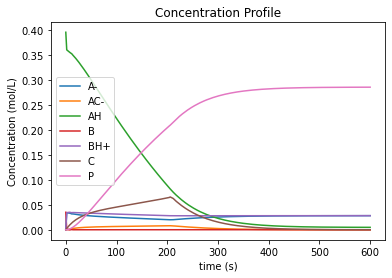

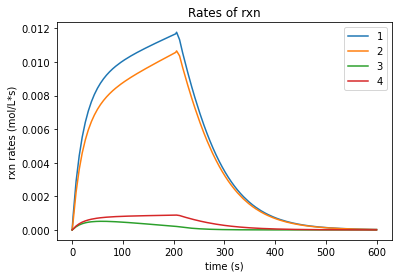

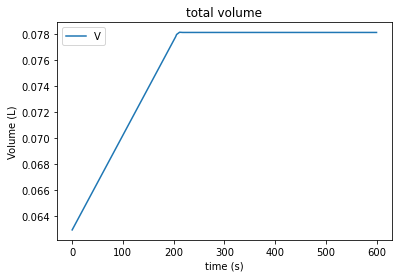

In [9]:
results.Z.plot.line(legend=True)
plt.xlabel("time (s)")
plt.ylabel("Concentration (mol/L)")
plt.title("Concentration Profile")
plt.show()

#results.Y[0].plot.line()
results.Y[1].plot.line(legend=True)
results.Y[2].plot.line(legend=True)
results.Y[3].plot.line(legend=True)
results.Y[4].plot.line(legend=True)
plt.xlabel("time (s)")
plt.ylabel("rxn rates (mol/L*s)")
plt.title("Rates of rxn")
plt.show()

results.X.plot.line(legend=True)
plt.xlabel("time (s)")
plt.ylabel("Volume (L)")
plt.title("total volume")
plt.show()